<a href="https://colab.research.google.com/github/paavanab/Style-Transfer-of-MRI-Images-Using-GANs-/blob/main/Style_transfer_using_GAN_Pavana_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style transfer using GAN


#### Submitted by Pavana B

pip install keras 


In [ ]:
#Import all the required libraries
# To access the data-set stored in the local system
import os
#Importing necessary library to import the images stored in local system
from tensorflow.keras.preprocessing import image_dataset_from_directory
#Importing tensorflow to build models
import tensorflow as tf 
#library to pre-process images
from tensorflow.image import random_flip_left_right
#to plot images
import matplotlib.pyplot as plt 
#for faster matrix calculations
import numpy as np 


## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [ ]:
tr1 = image_dataset_from_directory('dataset/Tr1', image_size = (256, 256), label_mode=None,color_mode="grayscale",batch_size=16,shuffle=True, seed=35) #write your code to create the dataset from image directory

Found 43 files belonging to 1 classes.


In [ ]:
tr2 = image_dataset_from_directory('dataset/Tr2/', image_size = (256, 256), label_mode=None,color_mode="grayscale", batch_size=16,shuffle=True, seed=35) #write your code to create the dataset from image directory

Found 46 files belonging to 1 classes.


In [ ]:
#checking shape of tr1

for i in next(iter(tr1)):
    print(i.shape)
    break

(256, 256, 1)


In [ ]:
#checking shape of tr2
for j in next(iter(tr2)):
    print(j.shape)
    break

(256, 256, 1)


The images were read in correct format

## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image/127.5)-1.0
    return image

In [ ]:
#preprocessing the images
def preprocess_image_train(image):
    image = random_flip_left_right(image)
    image = normalize(image)
    return image

In [ ]:
# process both classes of MRI images
tr1 = tr1.map(preprocess_image_train)
tr2 = tr2.map(preprocess_image_train)

In [ ]:
#creating sample tr1 and tr2
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

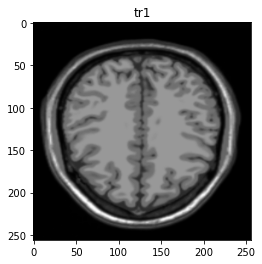

In [ ]:
#plotting tr1 sample
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

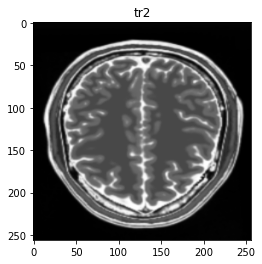

In [ ]:
#plotting tr2 sample
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
def unet_generator():
    down_stack = [downsample(64, 4, False), # (bs, 256, 256, 64)
       
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(128, 4), # (bs, 32, 32, 128)
        downsample(128, 4), # (bs, 16, 16, 128)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(128, 4), # (bs, 4, 4, 128)
        downsample(128, 4), # (bs, 2, 2, 128)
        downsample(128, 4)] # (bs, 1, 1, 128)]
    up_stack = [upsample(128, 4, True), # (bs, 2, 2, 128)
        upsample(128, 4, True), # (bs, 4, 4, 128)
        upsample(128, 4), # (bs, 8, 8, 128)
        upsample(128, 4), # (bs, 16, 16, 128)
        upsample(128, 4), # (bs, 32, 32, 128)
        upsample(128, 4), # (bs, 64, 64, 128)
        upsample(128, 4) # (bs, 128, 128,128)
      ] 
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator_g = unet_generator()#initialise the generator
generator_f = unet_generator()#initialise the generator

In [ ]:
#checking generator g summary
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 128)  262400      sequential_1[0][0]               
______________________________________________________________________________________________

In [ ]:
#checking generator f summary
generator_f.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 64) 1024        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 64, 64, 128)  131328      sequential_15[0][0]              
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 32, 32, 128)  262400      sequential_16[0][0]              
____________________________________________________________________________________________

In [ ]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x)#write your code to downsample X
    down2 = downsample(128, 4)(down1)#write your code to downsample down1
    down3 = downsample(256, 4)(down2)#write your code to downsample down2
    down4 = downsample(256, 4)(down3)#write your code to downsample down3
    down5 = downsample(256, 4)(down4)#write your code to downsample down4
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down5) # (bs, 10, 10, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)#create the model using input & output layer

In [ ]:
discriminator_x = discriminator()#initialise the discriminator
discriminator_y = discriminator()#initialise the discriminator

In [ ]:
#summary of discriminator x
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential_30 (Sequential)   (None, 128, 128, 64)      1024      
_________________________________________________________________
sequential_31 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_32 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
sequential_33 (Sequential)   (None, 16, 16, 256)       1049088   
_________________________________________________________________
sequential_34 (Sequential)   (None, 8, 8, 256)         1049088   
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 10, 10, 256)       0   

In [ ]:
#summary of discriminator y
discriminator_y.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential_35 (Sequential)   (None, 128, 128, 64)      1024      
_________________________________________________________________
sequential_36 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_37 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
sequential_38 (Sequential)   (None, 16, 16, 256)       1049088   
_________________________________________________________________
sequential_39 (Sequential)   (None, 8, 8, 256)         1049088   
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 10, 10, 256)       0   

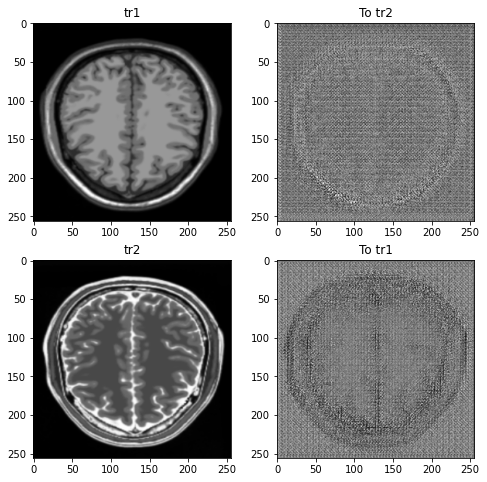

In [ ]:
#visualising a sample generator outputs
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [ ]:
#defining Lambda
LAMBDA = 100.0

In [ ]:
#Binary cross entropy loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#discriminator loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)#write your code here
    generated_loss = loss_obj(tf.zeros_like(generated), generated)#write your code here
    total_disc_loss = real_loss + generated_loss#write your code here
    return total_disc_loss * 0.5

In [ ]:
#generator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
#cycle loss
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))#write your code here
    return LAMBDA * loss1

In [ ]:
#identity loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return  0.5 * loss

In [ ]:
#defining the optimizers for both the generators and discriminators
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
#total number of epochs performed -175
EPOCHS = 175-169 

In [ ]:
#creating path and folder to store model training data and defining checkpoints
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
#function to plot the generated images
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True) #write your code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training=True) #write your code to generate images susiing Generator_f on fake_y
        
        fake_x = generator_f(real_y, training=True) #write your code to generate images using Generator_f on real_y
        cycled_y = generator_g(fake_x, training=True) #write your code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True) #write your code to generate images using Generator_f on real_x
        same_y = generator_g(real_y, training=True) #write your code to generate images using Generator_g on real_y
        
        disc_real_x = discriminator_x(real_x, training=True) #write your code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training=True) #write your code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x, training=True) #write your code to discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y, training=True) #write your code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y) #calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables) #write your code here
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables) #write your code here
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables) #write your code here
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables) #write your code here
    
    # Apply the gradients to the optimizer
    
    #write your code here
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

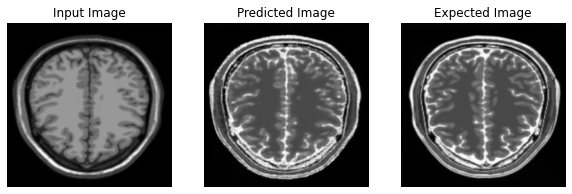

Saving checkpoint for epoch 0 at ./Trained_Model/ckpt-170


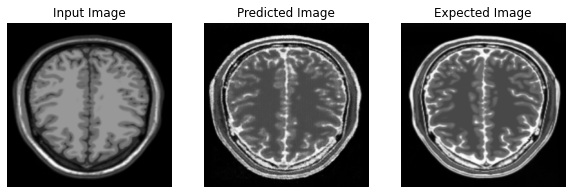

Saving checkpoint for epoch 1 at ./Trained_Model/ckpt-171


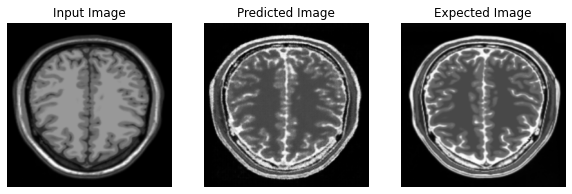

Saving checkpoint for epoch 2 at ./Trained_Model/ckpt-172


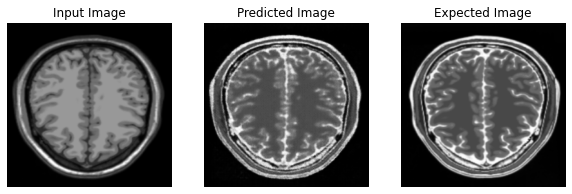

Saving checkpoint for epoch 3 at ./Trained_Model/ckpt-173


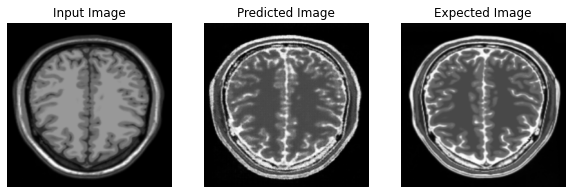

Saving checkpoint for epoch 4 at ./Trained_Model/ckpt-174


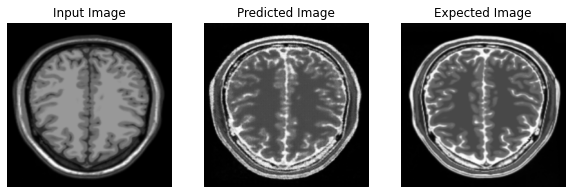

Saving checkpoint for epoch 5 at ./Trained_Model/ckpt-175


In [ ]:
#training the model
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

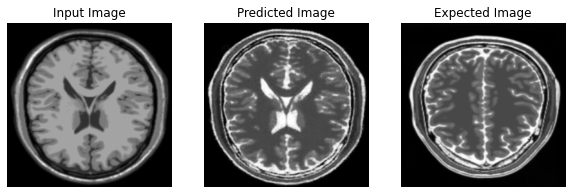

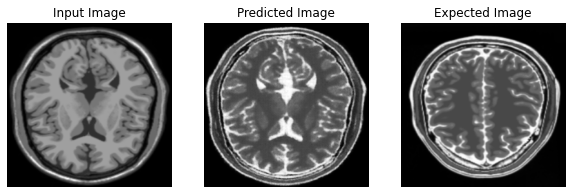

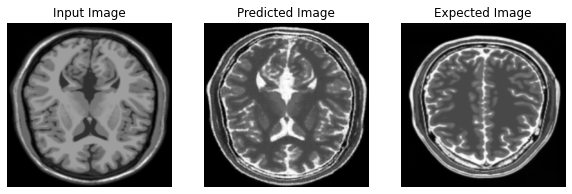

In [ ]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    generate_images(generator_g, inp, sample_tr2)

The trained model weights can be found here:
https://drive.google.com/drive/folders/13cBdA9n3GSkLuD3fXDZ65e-sFpJxZFo_?usp=sharing